# Infrared post-processing
We at Datagen provide infrared simulated renders as an integral part of our data. <br><br>

Since infrared renders have a high level of variability (different exposures, sensors, wavelength...), this notebook shows how to transform the original render to adapt it exactly to your needs. <br>

Besides reducing the domain gap, the transformations can be randomized on-the-fly, therefore increasing the level of variability in the data. <br><br>

The transformations are based on the pixel-perfect ground-truth modalities we provide, such as normal, depth and segmentation maps, and keypoints. <br><br>

In addition, for each of the infrared renders in the dataset we use, we generated an ambient light RGB version (using multiple lights in the platform). This additional render will let us add a background and additional reflections on the glasses. <br><br>

We have put a "Configurable" comment above each of the configurable parameters. Feel free to change them following your needs.

## Imports and dataset loading

In [50]:
from skimage.measure import EllipseModel
import datagen
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter
from dghelpers import imshow
from IPython.display import Image

random.seed(50354)
np.random.seed(871)

ds = datagen.load('../resources/faces_ir')
dp = ds[0]

## Original render
This is how the render looks like after having been downloaded from the platform

Text(0.5, 1.0, 'Infrared render')

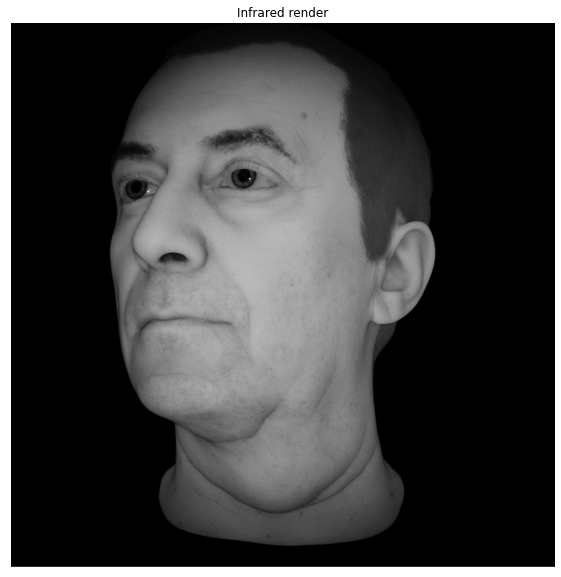

In [51]:
imshow(dp.infrared_spectrum)
plt.title('Infrared render')

## Blending function
In this notebook, we will make an extensive use of boolean masks to merge to images together. This function will let us perform the operation while eliminating the potential artifacts at the borders of the mask

In [52]:
def blend_images(background, foreground, mask, sigma=2):
    if type(mask) == np.ndarray:
        mask = gaussian_filter(mask.astype(float), sigma=sigma)
        if len(mask.shape) == 2:
            mask = mask[..., None]
    return (background * (1 - mask) + foreground * mask).astype(np.uint8)

## Skin
We'll implement the [Phong reflection model](https://en.wikipedia.org/wiki/Phong_reflection_model) to play with the specularities of the skin

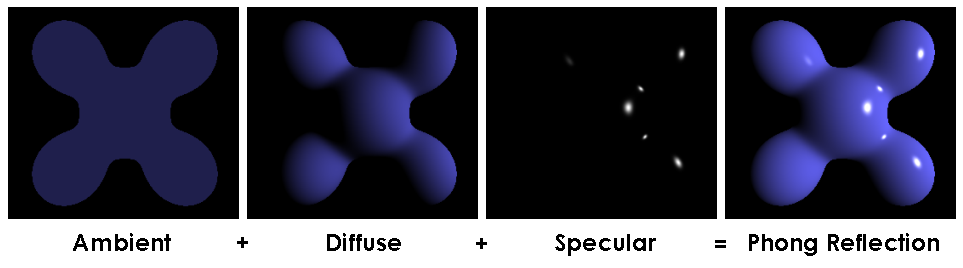

In [53]:
Image(filename='/Users/nathanael.bloch/Downloads/Phong.png', width=1200)


Let's first extract the normals map and pre-process it according to the [documentation](https://docs.datagen.tech/en/latest/Modalities/normal.html) to translate its values to the [-1, 1] range

In [54]:
normal_maps = dp.normal_maps.copy()
normal_maps = 2 * normal_maps - 1
normal_maps[..., 2] *= -1

We'll add some noise to the normals to make the reflection look more natural...

In [55]:
# Configurable. To cancel the noise, set normals_noise_factor = 1
normals_noise_factor = 1.3
normals_noise = np.random.uniform(low=1/normals_noise_factor, high=normals_noise_factor, size=normal_maps.shape)
normal_maps *= normals_noise

...and normalize the normals to make each of them a unit vector. <br>
The normals in the background are a zero vector, therefore we override their norm to avoid zero division.

In [56]:
norm = np.linalg.norm(normal_maps, axis=-1)
norm[norm == 0] = 1
normal_maps /= norm[..., None]

In order to apply transformation on the skin only, we have to unify all the skin segments into a single mask

Text(0.5, 1.0, 'Skin mask')

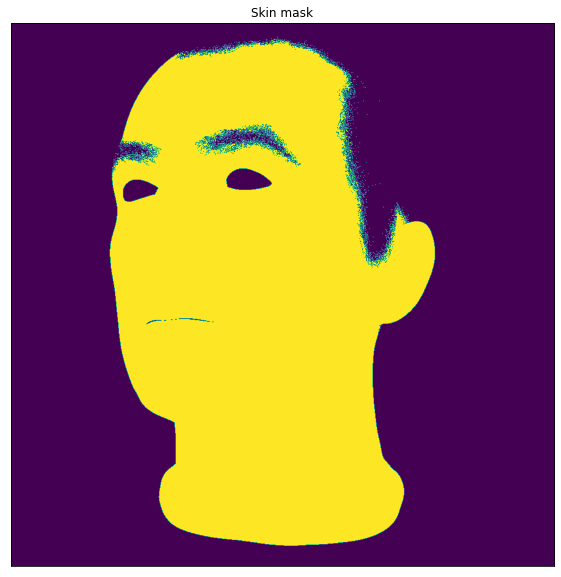

In [57]:
segmap = dp.semantic_segmentation
head_cmap = dp.semantic_segmentation_metadata.human.head
skin_mask = (segmap == head_cmap.skin.left) | (segmap == head_cmap.skin.right) | (segmap == head_cmap.nose.left) | \
            (segmap == head_cmap.nose.right) | (segmap == head_cmap.eye.left.tear_duct) | \
            (segmap == head_cmap.eye.right.tear_duct) | (segmap == head_cmap.eye.left.eyelid) | \
            (segmap == head_cmap.eye.right.eyelid) | (segmap == head_cmap.mouth.lips.top.left) | \
            (segmap == head_cmap.mouth.lips.top.right) | (segmap == head_cmap.mouth.lips.bottom.left) | \
            (segmap == head_cmap.mouth.lips.bottom.right) | (segmap == head_cmap.neck.left) | \
            (segmap == head_cmap.neck.right) | (segmap == head_cmap.ear.left) | (segmap == head_cmap.ear.right)

# Visualization of the results
imshow(skin_mask[..., 0])
plt.title('Skin mask')

To apply the Phong reflection formula, we need to get the XYZ coordinates of each of the pixels in the image, in the camera coordinates system. <br>
To perform the 3D reconstruction, we will leverage the intrinsic matrix and the depth map.<br><br>

Let's begin by creating three grids of X, Y and Z values, that follow the image dimensions:

In [58]:
height, width, _ = dp.infrared_spectrum.shape
yy, xx = np.meshgrid(range(height), range(width), indexing='ij')
zz = dp.depth[..., 0]

Since the Z grid comes from the depth map, it is already in camera coordinates. The X and Y grids are in image coordinates and have to be transformed to camera coordinates.<br>
We will use the intrinsic matrix and homogeneous coordinates to move from image coordinates to camera coordinates:

Text(0.5, 1.0, 'Pixels Z map')

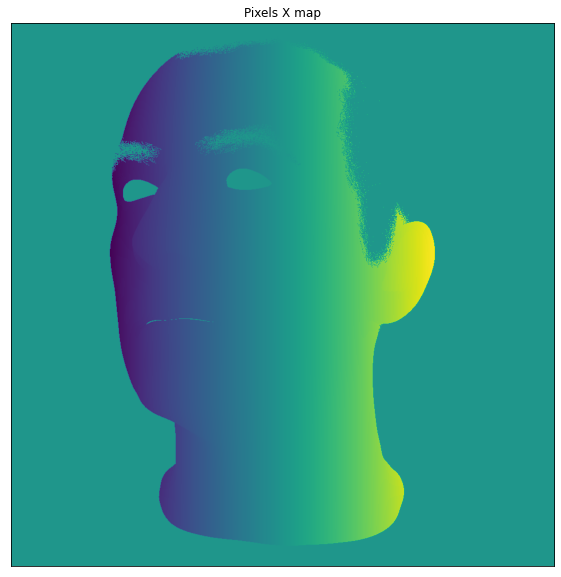

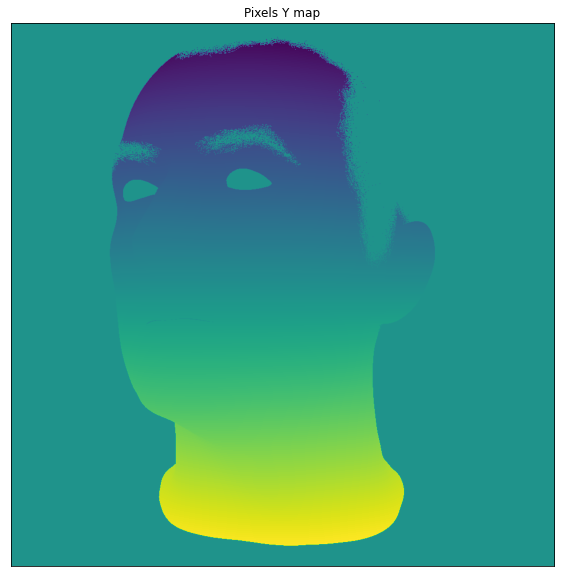

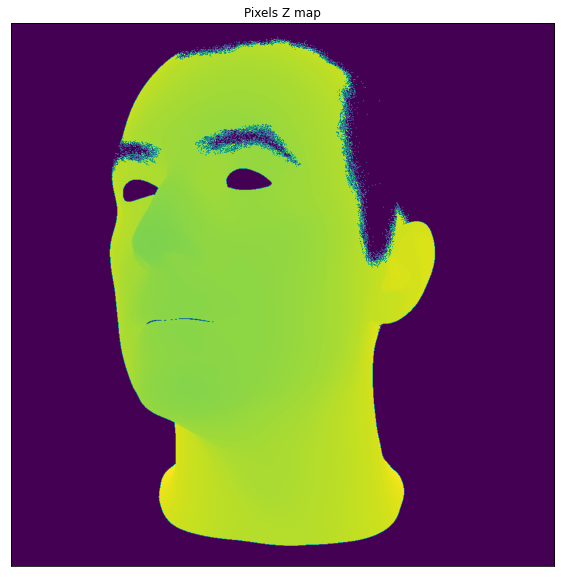

In [59]:
pixels_position_homogeneous = np.stack([xx * zz, yy * zz, zz], axis=2)
pixels_position_homogeneous = pixels_position_homogeneous.reshape(-1, 3).T
pixels_position_camera = (np.linalg.inv(dp.camera_metadata.intrinsic_matrix) @ pixels_position_homogeneous).T
pixels_position_camera = pixels_position_camera.reshape(height, width, 3)

# Visualization of the results
pixels_position_no_background = pixels_position_camera.copy()
pixels_position_no_background[~skin_mask] = 0
imshow(pixels_position_no_background[..., 0])
plt.title('Pixels X map')
imshow(pixels_position_no_background[..., 1])
plt.title('Pixels Y map')
imshow(pixels_position_no_background[..., 2])
plt.title('Pixels Z map')

Let's now define the Phong reflection parameters

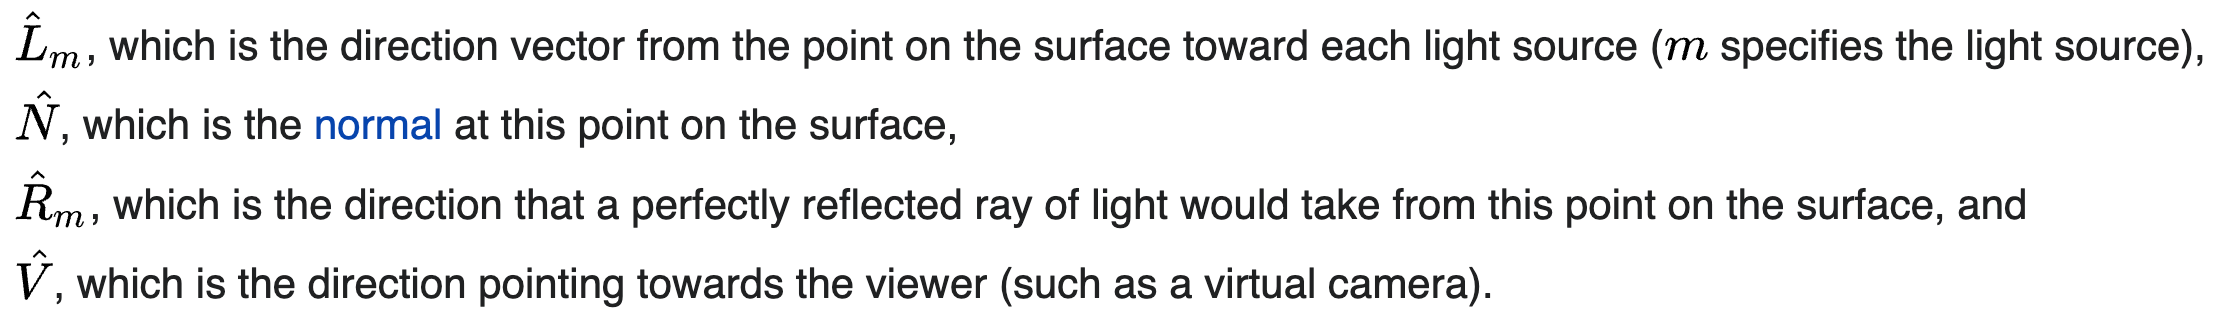

In [60]:
Image(filename='../docs/assets/phong1.png', width=1200)

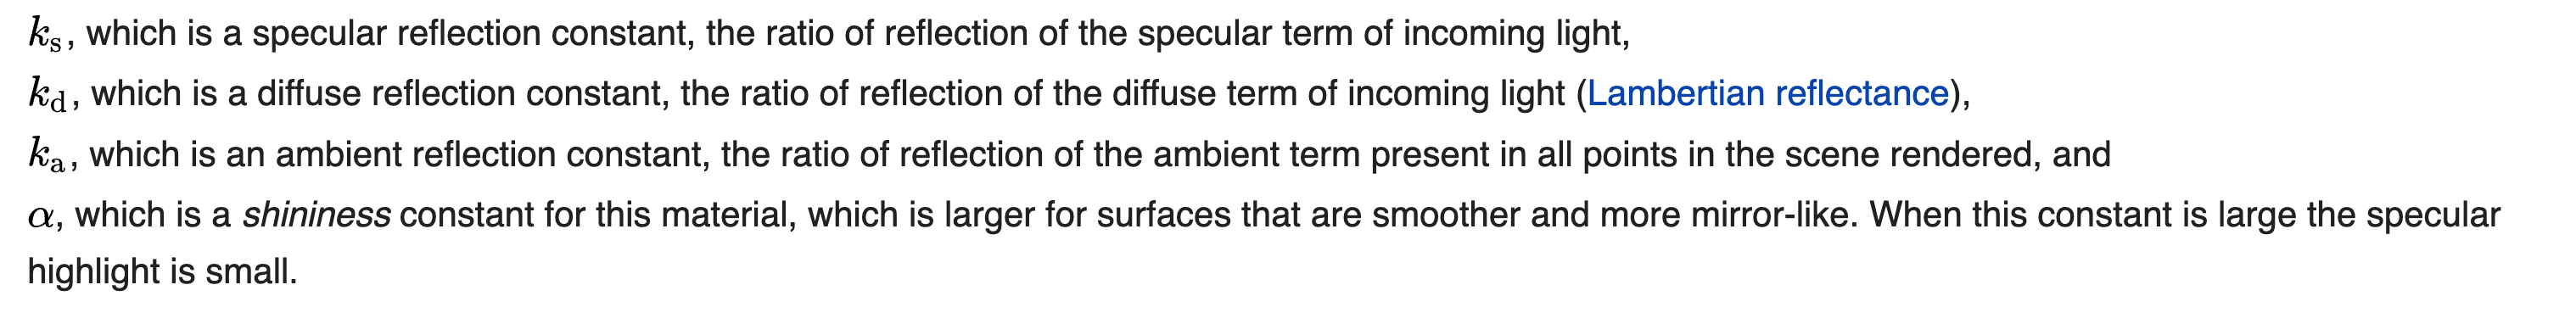

In [61]:
Image(filename='../docs/assets/phong2.png', width=1200)

We randomize the light intensity for increased variance, and set up the formula's parameters

In [62]:
# Configurable. By default at the same position as the camera
light_position = np.array([[[0, 0, 0]]])

L = (light_position - pixels_position_camera) / np.linalg.norm(pixels_position_camera, axis=-1)[..., None]
N = normal_maps
R = 2 * np.sum(L * N, axis=-1)[..., None] * N - L
V = L

# Configurable
light_intensity = random.uniform(0.8, 1.4)
k_a = 0.7
k_d = 0.1
k_s = 0.25
alpha = 6

The light intensity decreases quadratically with the distance from the source (for the diffuse and specular components)

In [63]:
I_radial = 1 / (dp.depth[..., 0]) ** 2
I_radial /= I_radial.max()
I_radial *= light_intensity

We apply the formula and blend skin of the new image with the rest of the old image

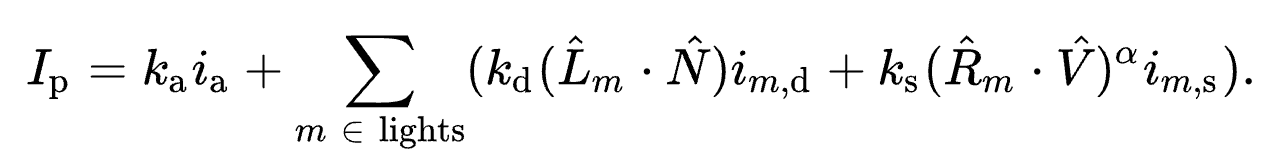

In [64]:
Image(filename='../docs/assets/phong3.png', width=1200)

Text(0.5, 1.0, 'Render after skin adjustment')

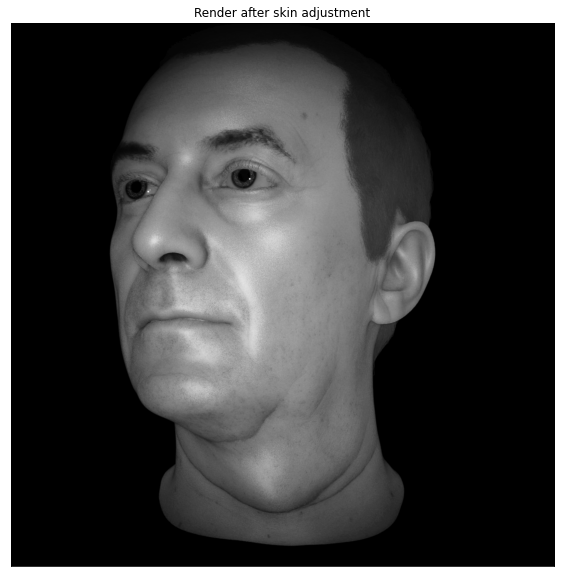

In [65]:
I_p = k_a * light_intensity + k_d * np.sum(L * N, axis=-1) * I_radial + k_s * np.sum(R * V, axis=-1) ** alpha * I_radial
img_specular = np.clip(I_p[..., None] * dp.infrared_spectrum, 0, 255).astype(np.uint8)
img = blend_images(dp.infrared_spectrum, img_specular, skin_mask)

# Visualization of the results
imshow(img)
plt.title('Render after skin adjustment')

## Eyes
We will now proceed to the eyes' color adjustment. <br>
The first step is to obtain the pupil's and iris' segmentation maps. For this purpose, we will use the eyes keypoints and fit an ellipse around them.

Text(0.5, 1.0, 'Eyes segmentation')

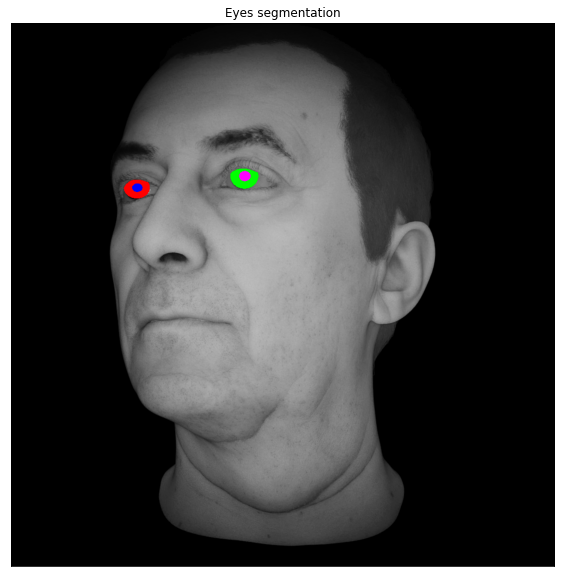

In [66]:
def get_ellipse_mask(ellipse_keypoints, height, width):
    ell = EllipseModel()
    ell.estimate(ellipse_keypoints)
    xc, yc, a, b, theta = ell.params
    yy, xx = np.meshgrid(range(height), range(width))
    in_ellipse = ((xx - xc) / a) ** 2 + ((yy - yc) / b) ** 2 < 1
    return in_ellipse


h, w, _ = dp.infrared_spectrum.shape
segmap = dp.semantic_segmentation

irises_keypoints = dp.actor_metadata.iris_circle.coords_2d[0]
pupils_keypoints = dp.actor_metadata.pupil_circle.coords_2d[0]

right_iris_mask = get_ellipse_mask(irises_keypoints.right_eye, h, w)
left_iris_mask = get_ellipse_mask(irises_keypoints.left_eye, h, w)
right_pupil_mask = get_ellipse_mask(pupils_keypoints.right_eye, h, w)
left_pupil_mask = get_ellipse_mask(pupils_keypoints.left_eye, h, w)

right_iris_mask[right_pupil_mask] = False
left_iris_mask[left_pupil_mask] = False

eye_cmap = dp.semantic_segmentation_metadata.human.head.eye
eyes_mask = (segmap == eye_cmap.left.eyeball) | (segmap == eye_cmap.right.eyeball)
eyes_mask = np.all(eyes_mask, axis=2)

right_iris_mask &= eyes_mask
left_iris_mask &= eyes_mask
right_pupil_mask &= eyes_mask
left_pupil_mask &= eyes_mask

# Visualization of the results
img_with_eye_segments = dp.infrared_spectrum.copy()
img_with_eye_segments[right_iris_mask] = np.array([255, 0, 0])
img_with_eye_segments[left_iris_mask] = np.array([0, 255, 0])
img_with_eye_segments[right_pupil_mask] = np.array([0, 0, 255])
img_with_eye_segments[left_pupil_mask] = np.array([255, 0, 255])

imshow(img_with_eye_segments)
plt.title('Eyes segmentation')

Now, we'll increase the brightness of the iris using gamma correction and the brightness of the pupil by simply adding a constant to the pixel values. The gamma and pupil shininess parameters are configurable.

Text(0.5, 1.0, 'Image with adjusted eyes')

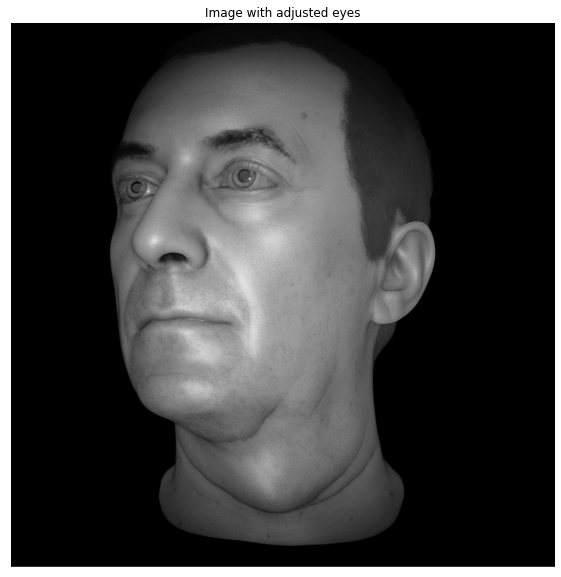

In [67]:
iris_mask = left_iris_mask | right_iris_mask
pupil_mask = left_pupil_mask | right_pupil_mask
pupil_mask[~eyes_mask] = 0


iris_mask = iris_mask[..., None].astype(float)
iris_mask = gaussian_filter(iris_mask, sigma=3)
iris_mask[~eyes_mask] = 0

pupil_mask = pupil_mask[..., None].astype(float)
pupil_mask = gaussian_filter(pupil_mask, sigma=0.8)

# Configurable. For the gamma value, the lower the brighter. For the shininess, the higher the brighter.
gamma_iris = random.uniform(1/3, 1/2)
pupil_shininess = random.uniform(0.15, 0.3)

img = img.astype(float) / 255
img = gaussian_filter((img ** gamma_iris), sigma=1) * iris_mask  + ((img + pupil_shininess) * pupil_mask)  + img * (1 - iris_mask - pupil_mask)
img = np.clip(img * 255, 0, 255).astype(np.uint8)

# Visualization of the results
imshow(img)
plt.title('Image with adjusted eyes')

## Hair and Eyebrows
We can also adjust the brightness of the hair and the eyebrows. To do so, we will apply gamma correction, as with the irises.

Text(0.5, 1.0, 'After hair adjustment')

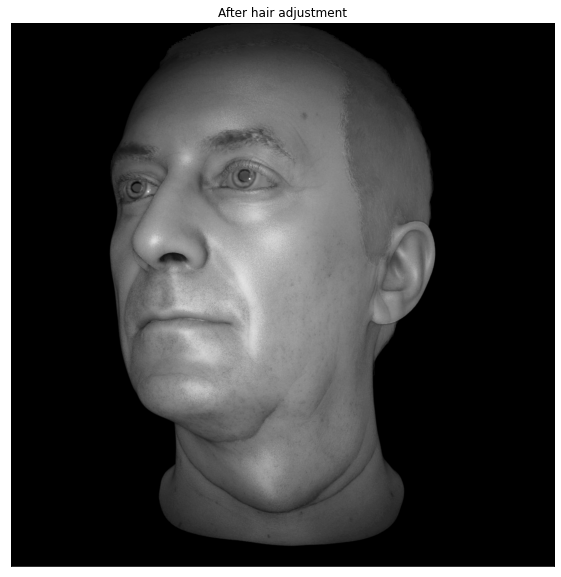

In [68]:
# TODO: Add beard
cmap = dp.semantic_segmentation_metadata.human.head
hair_mask = (segmap == cmap.hair) | (segmap == cmap.eyebrow.left) | (segmap == cmap.eyebrow.right)
hair_mask = hair_mask.astype(float)
hair_mask = gaussian_filter(hair_mask, sigma=1)

# Configurable. The lower the brighter
gamma_hair = 0.6

gamma_corrected_img = (((img /255) ** gamma_hair)*255).astype(np.uint8)
img = blend_images(img, gamma_corrected_img, hair_mask)

# Visualization of the results
imshow(img)
plt.title('After hair adjustment')

## Noise
Most infrared images are not so sharp and have some level of noise. As a final touch, we will slightly blur the image:

Text(0.5, 1.0, 'Blurred image')

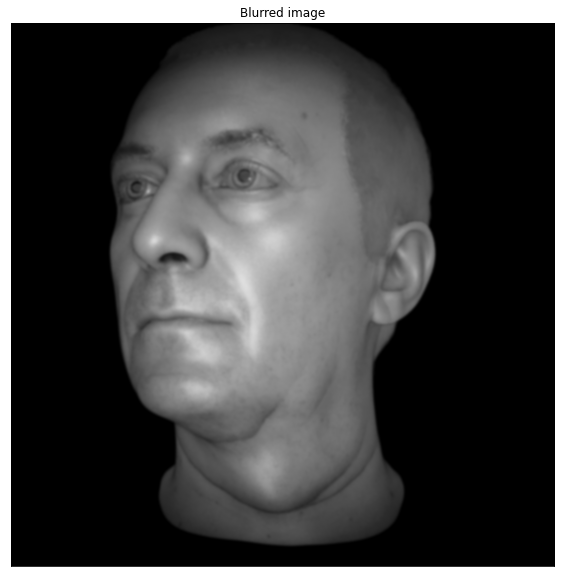

In [69]:
img = gaussian_filter(img, sigma=2)

imshow(img)
plt.title('Blurred image')

## Glasses reflectiveness (for multiple-light renders only)
The infrared lighting currently assume a single spotlight close to the camera, without ambient light.<br>
Let's say that we want to add some natural reflection to the glasses to make our neural network more robust. We can take the reflection from the ambient light render and incorporate it into the infrared render:

Text(0.5, 1.0, 'Natural lighting image')

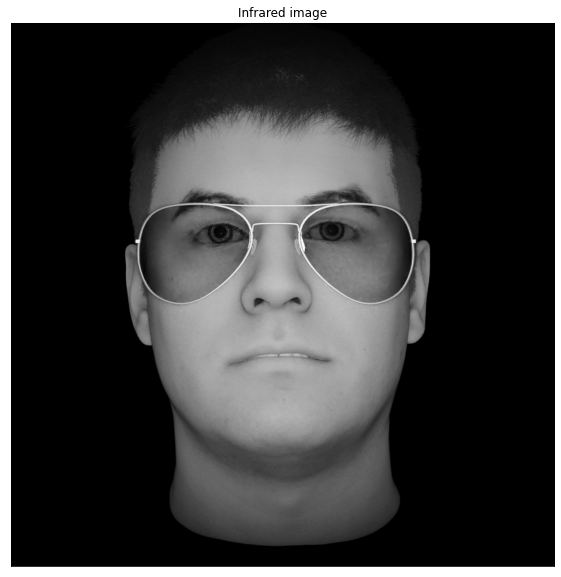

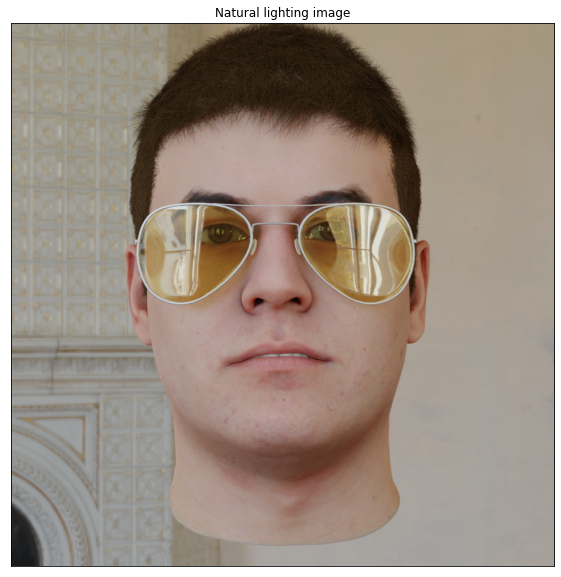

In [70]:
dp = ds[1]
imshow(dp.infrared_spectrum)
plt.title('Infrared image')
imshow(dp.visible_spectrum)
plt.title('Natural lighting image')

Text(0.5, 1.0, 'Glasses segmentation')

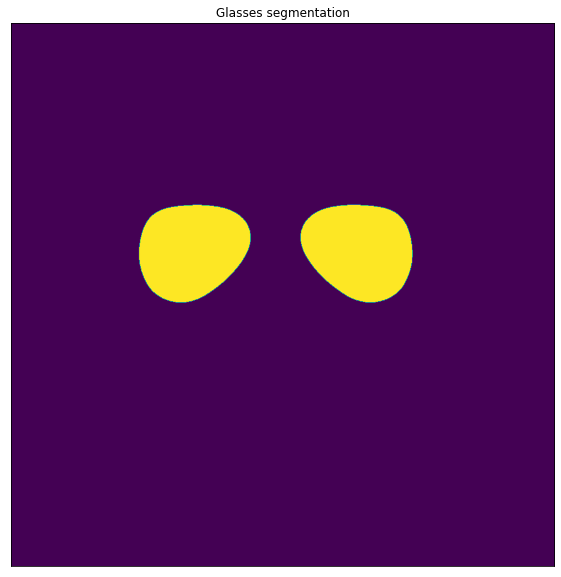

In [71]:
# Configurable
ambient_ratio = 0.5

segmap = dp.semantic_segmentation
cmap = dp.semantic_segmentation_metadata.glasses.lens
glasses_mask = (segmap == cmap.right) | (segmap == cmap.left)

# Visualization of the results
imshow(glasses_mask[..., 0])
plt.title('Glasses segmentation')

Text(0.5, 1.0, 'After glasses adjustment')

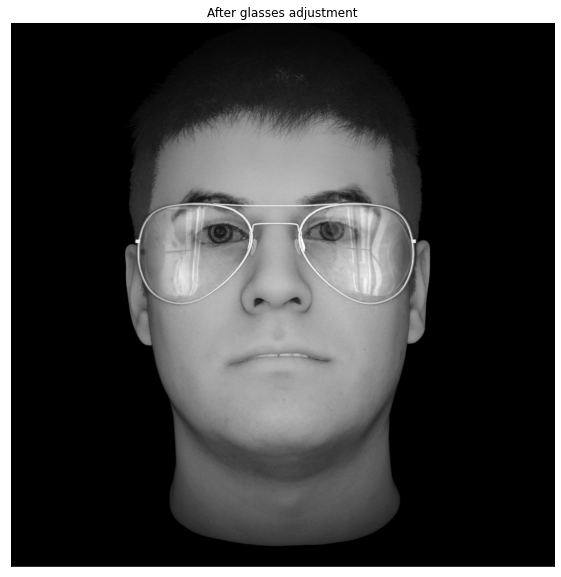

In [72]:
img_gray = np.repeat(dp.visible_spectrum.mean(axis=-1)[..., None], 3, axis=-1)
blended_img = np.clip(dp.infrared_spectrum + ambient_ratio * img_gray, 0, 255)
img = blend_images(dp.infrared_spectrum, blended_img, glasses_mask)

# Visualization of the results
imshow(img)
plt.title('After glasses adjustment')

## Background (for multiple-light renders only)
If we want a background that is not black, we can also use the background from the natural lighting render and incorporate it into the infrared render.

Text(0.5, 1.0, 'After background adjustment')

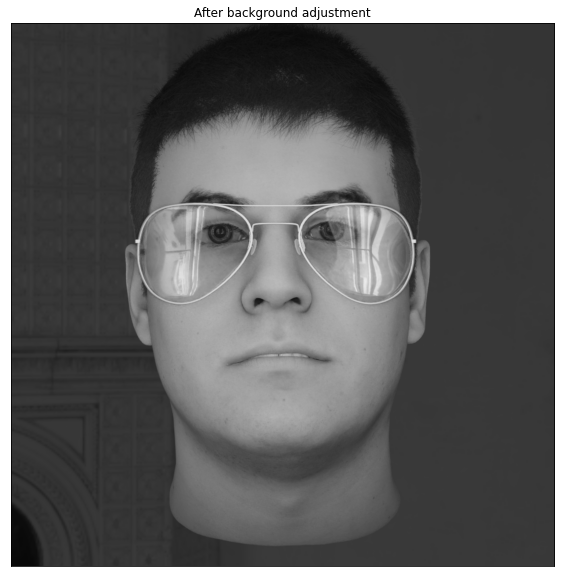

In [73]:
# Configurable. How much of the natural background is visible in the image
ambient_ratio = random.uniform(0, 0.5)

visible_spectrum_gray = dp.visible_spectrum.mean(axis=-1)
img = blend_images(img, visible_spectrum_gray[..., None], ambient_ratio)

# Visualization of the results
imshow(img)
plt.title('After background adjustment')